In [5]:
import torch.nn.functional as F
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [6]:
import torch
torch.__version__
torch.cuda.is_available()

True

In [7]:
# 定義CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 80 * 80, 512)
        self.fc2 = nn.Linear(512, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 80 * 80)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
# 設置裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數
num_epochs = 25
batch_size = 8
learning_rate = 0.001

# 數據讀取和預處理
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/kevinluo/breast_density_classification/datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [9]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [10]:
def train_model(model, criterion, optimizer, num_epochs):
    train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_accuracies.append(epoch_acc)

    return model, train_losses, valid_losses, train_accuracies, valid_accuracies


In [11]:
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/25
----------


  8%|▊         | 40/526 [00:10<02:09,  3.77it/s]


KeyboardInterrupt: 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

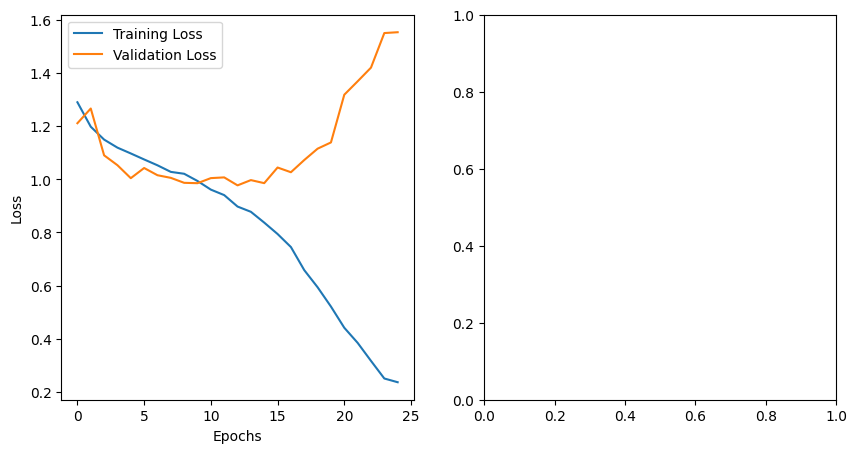

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#生成混淆矩陣和各種指標報告
y_true, y_pred = [], []
model.eval()
for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(preds.detach().cpu().numpy())

labels_list = sorted(list(set(y_true)))
print(confusion_matrix(y_true, y_pred, labels=labels_list))
print(classification_report(y_true, y_pred, labels=labels_list, target_names=class_names))

## 換成Regression

In [ ]:
# def __getitem__(self, idx):
#     img_path = self.img_paths[idx]
#     target = float(self.classes.index(img_path.parent.name) + 1) / 4
#     image = Image.open(img_path).convert('RGB')
#     image = self.transform(image)
#     return image, target


In [ ]:
#labels = labels.to(device).float() / 4



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt


class BreastDensityDataset(ImageFolder):
    def __getitem__(self, idx):
        img_path, _ = self.imgs[idx]
        img_path = Path(img_path)
        target = float(self.classes.index(img_path.parent.name) + 1) / 4
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, target



data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
    ]),
}

data_dir = '/home/kevinluo/breast_density_classification/datasets'
datasets = {x: BreastDensityDataset(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}
class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
num_workers = 2
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'valid', 'test']}

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 80 * 80, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 80 * 80)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 1


In [13]:
def train_model(model, criterion, optimizer, num_epochs):
    train_losses, valid_losses, train_mse, valid_mse = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_mse = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                #running_mse += torch.sum((outputs - labels) ** 2)
                running_mse += torch.sum((outputs - labels) ** 2).cpu().item()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} MSE: {epoch_mse:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_mse.append(epoch_mse)
            else:
                valid_losses.append(epoch_loss)
                valid_mse.append(epoch_mse)

    return model, train_losses, valid_losses, train_mse, valid_mse


In [14]:
from pathlib import Path

In [17]:
model, train_losses, valid_losses, train_mse, valid_mse = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------


100%|██████████| 526/526 [02:51<00:00,  3.06it/s]


Train Loss: 0.0554 MSE: 0.0554


100%|██████████| 54/54 [00:18<00:00,  2.92it/s]


Valid Loss: 0.0412 MSE: 0.0412
Epoch 2/10
----------


100%|██████████| 526/526 [02:53<00:00,  3.03it/s]


Train Loss: 0.0454 MSE: 0.0454


100%|██████████| 54/54 [00:17<00:00,  3.13it/s]


Valid Loss: 0.0476 MSE: 0.0476
Epoch 3/10
----------


100%|██████████| 526/526 [02:47<00:00,  3.15it/s]


Train Loss: 0.0438 MSE: 0.0438


100%|██████████| 54/54 [00:21<00:00,  2.55it/s]


Valid Loss: 0.0395 MSE: 0.0395
Epoch 4/10
----------


100%|██████████| 526/526 [02:59<00:00,  2.92it/s]


Train Loss: 0.0441 MSE: 0.0441


100%|██████████| 54/54 [00:16<00:00,  3.22it/s]


Valid Loss: 0.0384 MSE: 0.0384
Epoch 5/10
----------


100%|██████████| 526/526 [02:49<00:00,  3.10it/s]


Train Loss: 0.0425 MSE: 0.0425


100%|██████████| 54/54 [00:18<00:00,  2.85it/s]


Valid Loss: 0.0385 MSE: 0.0385
Epoch 6/10
----------


100%|██████████| 526/526 [02:41<00:00,  3.26it/s]


Train Loss: 0.0409 MSE: 0.0409


100%|██████████| 54/54 [00:18<00:00,  2.95it/s]


Valid Loss: 0.0383 MSE: 0.0383
Epoch 7/10
----------


100%|██████████| 526/526 [02:44<00:00,  3.20it/s]


Train Loss: 0.0399 MSE: 0.0399


100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


Valid Loss: 0.0364 MSE: 0.0364
Epoch 8/10
----------


100%|██████████| 526/526 [02:37<00:00,  3.34it/s]


Train Loss: 0.0396 MSE: 0.0396


100%|██████████| 54/54 [00:17<00:00,  3.02it/s]


Valid Loss: 0.0348 MSE: 0.0348
Epoch 9/10
----------


100%|██████████| 526/526 [02:38<00:00,  3.33it/s]


Train Loss: 0.0384 MSE: 0.0384


100%|██████████| 54/54 [00:21<00:00,  2.50it/s]


Valid Loss: 0.0370 MSE: 0.0370
Epoch 10/10
----------


100%|██████████| 526/526 [02:58<00:00,  2.94it/s]


Train Loss: 0.0386 MSE: 0.0386


100%|██████████| 54/54 [00:15<00:00,  3.39it/s]

Valid Loss: 0.0395 MSE: 0.0395


In [24]:
model, train_losses, valid_losses, train_mse, valid_mse = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/1
----------


100%|██████████| 526/526 [02:52<00:00,  3.04it/s]


Train Loss: 0.0562 MSE: 0.0562


100%|██████████| 54/54 [00:17<00:00,  3.12it/s]

Valid Loss: 0.0423 MSE: 0.0423


## 只計算MSE loss

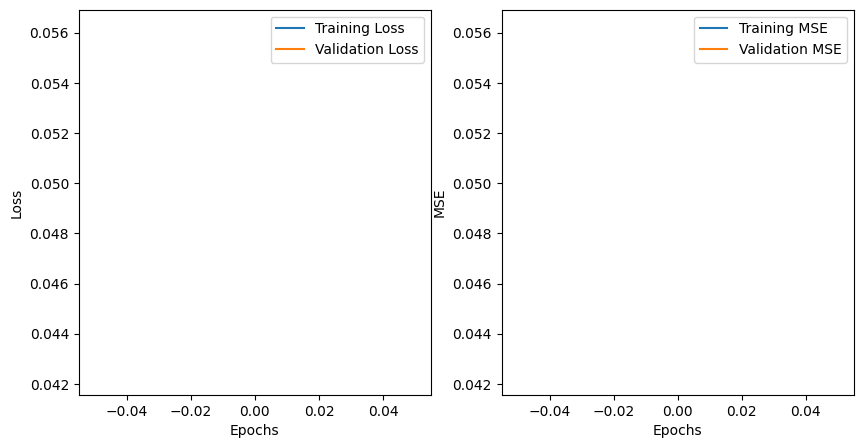

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mse, label="Training MSE")
plt.plot(valid_mse, label="Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

plt.show()

### 我也要accuracy和confusion matrix

#train_model 改成...


In [15]:
def train_model(model, criterion, optimizer, num_epochs):
    train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_mse = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    preds = (outputs * 4).round()
                    targets = (labels * 4)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_mse += torch.sum((outputs - labels) ** 2).cpu().item()
                running_corrects += torch.sum(preds == targets).cpu().item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} MSE: {epoch_mse:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_mse.append(epoch_mse)
                train_acc.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_mse.append(epoch_mse)
                valid_acc.append(epoch_acc)

    return model, train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc


In [16]:
model, train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc = train_model(model, criterion, optimizer, 100)


Epoch 1/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.28it/s]


Train Loss: 0.0548 MSE: 0.0548 Acc: 0.3840


100%|██████████| 54/54 [00:14<00:00,  3.62it/s]


Valid Loss: 0.0481 MSE: 0.0481 Acc: 0.4535
Epoch 2/100
----------


100%|██████████| 526/526 [02:42<00:00,  3.24it/s]


Train Loss: 0.0466 MSE: 0.0466 Acc: 0.4232


100%|██████████| 54/54 [00:16<00:00,  3.35it/s]


Valid Loss: 0.0397 MSE: 0.0397 Acc: 0.4651
Epoch 3/100
----------


100%|██████████| 526/526 [02:42<00:00,  3.24it/s]


Train Loss: 0.0445 MSE: 0.0445 Acc: 0.4244


100%|██████████| 54/54 [00:15<00:00,  3.54it/s]


Valid Loss: 0.0429 MSE: 0.0429 Acc: 0.4674
Epoch 4/100
----------


100%|██████████| 526/526 [02:31<00:00,  3.46it/s]


Train Loss: 0.0434 MSE: 0.0434 Acc: 0.4365


100%|██████████| 54/54 [00:16<00:00,  3.24it/s]


Valid Loss: 0.0461 MSE: 0.0461 Acc: 0.4488
Epoch 5/100
----------


100%|██████████| 526/526 [02:26<00:00,  3.60it/s]


Train Loss: 0.0425 MSE: 0.0425 Acc: 0.4315


100%|██████████| 54/54 [00:16<00:00,  3.21it/s]


Valid Loss: 0.0374 MSE: 0.0374 Acc: 0.4744
Epoch 6/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0418 MSE: 0.0418 Acc: 0.4394


100%|██████████| 54/54 [00:15<00:00,  3.43it/s]


Valid Loss: 0.0371 MSE: 0.0371 Acc: 0.4907
Epoch 7/100
----------


100%|██████████| 526/526 [02:43<00:00,  3.22it/s]


Train Loss: 0.0412 MSE: 0.0412 Acc: 0.4417


100%|██████████| 54/54 [00:15<00:00,  3.50it/s]


Valid Loss: 0.0369 MSE: 0.0369 Acc: 0.4674
Epoch 8/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.27it/s]


Train Loss: 0.0399 MSE: 0.0399 Acc: 0.4622


100%|██████████| 54/54 [00:19<00:00,  2.84it/s]


Valid Loss: 0.0355 MSE: 0.0355 Acc: 0.5116
Epoch 9/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.43it/s]


Train Loss: 0.0394 MSE: 0.0394 Acc: 0.4629


100%|██████████| 54/54 [00:18<00:00,  2.85it/s]


Valid Loss: 0.0352 MSE: 0.0352 Acc: 0.4558
Epoch 10/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.32it/s]


Train Loss: 0.0388 MSE: 0.0388 Acc: 0.4705


100%|██████████| 54/54 [00:16<00:00,  3.30it/s]


Valid Loss: 0.0395 MSE: 0.0395 Acc: 0.4814
Epoch 11/100
----------


100%|██████████| 526/526 [02:45<00:00,  3.19it/s]


Train Loss: 0.0379 MSE: 0.0379 Acc: 0.4667


100%|██████████| 54/54 [00:15<00:00,  3.40it/s]


Valid Loss: 0.0350 MSE: 0.0350 Acc: 0.5047
Epoch 12/100
----------


100%|██████████| 526/526 [02:34<00:00,  3.40it/s]


Train Loss: 0.0378 MSE: 0.0378 Acc: 0.4765


100%|██████████| 54/54 [00:14<00:00,  3.73it/s]


Valid Loss: 0.0350 MSE: 0.0350 Acc: 0.4791
Epoch 13/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0373 MSE: 0.0373 Acc: 0.4689


100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


Valid Loss: 0.0370 MSE: 0.0370 Acc: 0.5000
Epoch 14/100
----------


100%|██████████| 526/526 [02:42<00:00,  3.24it/s]


Train Loss: 0.0374 MSE: 0.0374 Acc: 0.4724


100%|██████████| 54/54 [00:16<00:00,  3.21it/s]


Valid Loss: 0.0341 MSE: 0.0341 Acc: 0.5047
Epoch 15/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0366 MSE: 0.0366 Acc: 0.4788


100%|██████████| 54/54 [00:18<00:00,  2.89it/s]


Valid Loss: 0.0382 MSE: 0.0382 Acc: 0.5047
Epoch 16/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.34it/s]


Train Loss: 0.0362 MSE: 0.0362 Acc: 0.4850


100%|██████████| 54/54 [00:16<00:00,  3.36it/s]


Valid Loss: 0.0400 MSE: 0.0400 Acc: 0.4512
Epoch 17/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0364 MSE: 0.0364 Acc: 0.4872


100%|██████████| 54/54 [00:17<00:00,  3.05it/s]


Valid Loss: 0.0339 MSE: 0.0339 Acc: 0.5209
Epoch 18/100
----------


100%|██████████| 526/526 [02:32<00:00,  3.46it/s]


Train Loss: 0.0355 MSE: 0.0355 Acc: 0.4883


100%|██████████| 54/54 [00:19<00:00,  2.84it/s]


Valid Loss: 0.0354 MSE: 0.0354 Acc: 0.4744
Epoch 19/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0357 MSE: 0.0357 Acc: 0.4793


100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


Valid Loss: 0.0330 MSE: 0.0330 Acc: 0.5093
Epoch 20/100
----------


100%|██████████| 526/526 [02:28<00:00,  3.53it/s]


Train Loss: 0.0349 MSE: 0.0349 Acc: 0.4857


100%|██████████| 54/54 [00:15<00:00,  3.40it/s]


Valid Loss: 0.0341 MSE: 0.0341 Acc: 0.5070
Epoch 21/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.35it/s]


Train Loss: 0.0351 MSE: 0.0351 Acc: 0.4907


100%|██████████| 54/54 [00:16<00:00,  3.37it/s]


Valid Loss: 0.0352 MSE: 0.0352 Acc: 0.4907
Epoch 22/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.31it/s]


Train Loss: 0.0340 MSE: 0.0340 Acc: 0.4976


100%|██████████| 54/54 [00:16<00:00,  3.31it/s]


Valid Loss: 0.0347 MSE: 0.0347 Acc: 0.5070
Epoch 23/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.35it/s]


Train Loss: 0.0336 MSE: 0.0336 Acc: 0.4938


100%|██████████| 54/54 [00:16<00:00,  3.20it/s]


Valid Loss: 0.0339 MSE: 0.0339 Acc: 0.4953
Epoch 24/100
----------


100%|██████████| 526/526 [02:46<00:00,  3.16it/s]


Train Loss: 0.0337 MSE: 0.0337 Acc: 0.4931


100%|██████████| 54/54 [00:16<00:00,  3.22it/s]


Valid Loss: 0.0332 MSE: 0.0332 Acc: 0.4953
Epoch 25/100
----------


100%|██████████| 526/526 [02:25<00:00,  3.62it/s]


Train Loss: 0.0332 MSE: 0.0332 Acc: 0.5026


100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


Valid Loss: 0.0338 MSE: 0.0338 Acc: 0.5163
Epoch 26/100
----------


100%|██████████| 526/526 [02:35<00:00,  3.38it/s]


Train Loss: 0.0332 MSE: 0.0332 Acc: 0.5021


100%|██████████| 54/54 [00:16<00:00,  3.35it/s]


Valid Loss: 0.0329 MSE: 0.0329 Acc: 0.5163
Epoch 27/100
----------


100%|██████████| 526/526 [02:26<00:00,  3.59it/s]


Train Loss: 0.0334 MSE: 0.0334 Acc: 0.5048


100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


Valid Loss: 0.0333 MSE: 0.0333 Acc: 0.5140
Epoch 28/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.28it/s]


Train Loss: 0.0328 MSE: 0.0328 Acc: 0.4988


100%|██████████| 54/54 [00:14<00:00,  3.62it/s]


Valid Loss: 0.0329 MSE: 0.0329 Acc: 0.5186
Epoch 29/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0321 MSE: 0.0321 Acc: 0.5093


100%|██████████| 54/54 [00:16<00:00,  3.33it/s]


Valid Loss: 0.0358 MSE: 0.0358 Acc: 0.5326
Epoch 30/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.28it/s]


Train Loss: 0.0318 MSE: 0.0318 Acc: 0.5062


100%|██████████| 54/54 [00:20<00:00,  2.62it/s]


Valid Loss: 0.0323 MSE: 0.0323 Acc: 0.5186
Epoch 31/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0315 MSE: 0.0315 Acc: 0.5147


100%|██████████| 54/54 [00:18<00:00,  2.94it/s]


Valid Loss: 0.0341 MSE: 0.0341 Acc: 0.5163
Epoch 32/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.34it/s]


Train Loss: 0.0315 MSE: 0.0315 Acc: 0.5100


100%|██████████| 54/54 [00:17<00:00,  3.16it/s]


Valid Loss: 0.0345 MSE: 0.0345 Acc: 0.5070
Epoch 33/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.29it/s]


Train Loss: 0.0315 MSE: 0.0315 Acc: 0.5143


100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


Valid Loss: 0.0346 MSE: 0.0346 Acc: 0.5186
Epoch 34/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0308 MSE: 0.0308 Acc: 0.5214


100%|██████████| 54/54 [00:16<00:00,  3.20it/s]


Valid Loss: 0.0347 MSE: 0.0347 Acc: 0.5116
Epoch 35/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.35it/s]


Train Loss: 0.0304 MSE: 0.0304 Acc: 0.5214


100%|██████████| 54/54 [00:18<00:00,  2.89it/s]


Valid Loss: 0.0331 MSE: 0.0331 Acc: 0.5070
Epoch 36/100
----------


100%|██████████| 526/526 [02:44<00:00,  3.20it/s]


Train Loss: 0.0298 MSE: 0.0298 Acc: 0.5357


100%|██████████| 54/54 [00:18<00:00,  2.98it/s]


Valid Loss: 0.0316 MSE: 0.0316 Acc: 0.5279
Epoch 37/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0298 MSE: 0.0298 Acc: 0.5302


100%|██████████| 54/54 [00:19<00:00,  2.80it/s]


Valid Loss: 0.0318 MSE: 0.0318 Acc: 0.5186
Epoch 38/100
----------


100%|██████████| 526/526 [02:34<00:00,  3.40it/s]


Train Loss: 0.0297 MSE: 0.0297 Acc: 0.5259


100%|██████████| 54/54 [00:15<00:00,  3.44it/s]


Valid Loss: 0.0310 MSE: 0.0310 Acc: 0.5442
Epoch 39/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0285 MSE: 0.0285 Acc: 0.5390


100%|██████████| 54/54 [00:15<00:00,  3.60it/s]


Valid Loss: 0.0329 MSE: 0.0329 Acc: 0.5140
Epoch 40/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0286 MSE: 0.0286 Acc: 0.5428


100%|██████████| 54/54 [00:16<00:00,  3.35it/s]


Valid Loss: 0.0320 MSE: 0.0320 Acc: 0.5279
Epoch 41/100
----------


100%|██████████| 526/526 [02:46<00:00,  3.16it/s]


Train Loss: 0.0285 MSE: 0.0285 Acc: 0.5340


100%|██████████| 54/54 [00:17<00:00,  3.13it/s]


Valid Loss: 0.0334 MSE: 0.0334 Acc: 0.5558
Epoch 42/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.28it/s]


Train Loss: 0.0281 MSE: 0.0281 Acc: 0.5345


100%|██████████| 54/54 [00:15<00:00,  3.44it/s]


Valid Loss: 0.0308 MSE: 0.0308 Acc: 0.5256
Epoch 43/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0279 MSE: 0.0279 Acc: 0.5409


100%|██████████| 54/54 [00:16<00:00,  3.24it/s]


Valid Loss: 0.0297 MSE: 0.0297 Acc: 0.5488
Epoch 44/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0273 MSE: 0.0273 Acc: 0.5492


100%|██████████| 54/54 [00:15<00:00,  3.40it/s]


Valid Loss: 0.0304 MSE: 0.0304 Acc: 0.5326
Epoch 45/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.32it/s]


Train Loss: 0.0270 MSE: 0.0270 Acc: 0.5533


100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


Valid Loss: 0.0300 MSE: 0.0300 Acc: 0.5465
Epoch 46/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.32it/s]


Train Loss: 0.0272 MSE: 0.0272 Acc: 0.5568


100%|██████████| 54/54 [00:15<00:00,  3.42it/s]


Valid Loss: 0.0300 MSE: 0.0300 Acc: 0.5558
Epoch 47/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.36it/s]


Train Loss: 0.0268 MSE: 0.0268 Acc: 0.5523


100%|██████████| 54/54 [00:15<00:00,  3.39it/s]


Valid Loss: 0.0303 MSE: 0.0303 Acc: 0.5581
Epoch 48/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0264 MSE: 0.0264 Acc: 0.5587


100%|██████████| 54/54 [00:15<00:00,  3.42it/s]


Valid Loss: 0.0310 MSE: 0.0310 Acc: 0.5395
Epoch 49/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.34it/s]


Train Loss: 0.0258 MSE: 0.0258 Acc: 0.5630


100%|██████████| 54/54 [00:15<00:00,  3.49it/s]


Valid Loss: 0.0315 MSE: 0.0315 Acc: 0.5326
Epoch 50/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.35it/s]


Train Loss: 0.0256 MSE: 0.0256 Acc: 0.5682


100%|██████████| 54/54 [00:17<00:00,  3.11it/s]


Valid Loss: 0.0296 MSE: 0.0296 Acc: 0.5674
Epoch 51/100
----------


100%|██████████| 526/526 [02:31<00:00,  3.46it/s]


Train Loss: 0.0250 MSE: 0.0250 Acc: 0.5806


100%|██████████| 54/54 [00:14<00:00,  3.67it/s]


Valid Loss: 0.0296 MSE: 0.0296 Acc: 0.5674
Epoch 52/100
----------


100%|██████████| 526/526 [02:23<00:00,  3.66it/s]


Train Loss: 0.0249 MSE: 0.0249 Acc: 0.5668


100%|██████████| 54/54 [00:19<00:00,  2.82it/s]


Valid Loss: 0.0299 MSE: 0.0299 Acc: 0.5628
Epoch 53/100
----------


100%|██████████| 526/526 [02:41<00:00,  3.26it/s]


Train Loss: 0.0248 MSE: 0.0248 Acc: 0.5670


100%|██████████| 54/54 [00:16<00:00,  3.20it/s]


Valid Loss: 0.0296 MSE: 0.0296 Acc: 0.5674
Epoch 54/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.35it/s]


Train Loss: 0.0242 MSE: 0.0242 Acc: 0.5799


100%|██████████| 54/54 [00:15<00:00,  3.38it/s]


Valid Loss: 0.0307 MSE: 0.0307 Acc: 0.5093
Epoch 55/100
----------


100%|██████████| 526/526 [02:41<00:00,  3.27it/s]


Train Loss: 0.0238 MSE: 0.0238 Acc: 0.5856


100%|██████████| 54/54 [00:15<00:00,  3.44it/s]


Valid Loss: 0.0321 MSE: 0.0321 Acc: 0.5302
Epoch 56/100
----------


100%|██████████| 526/526 [02:41<00:00,  3.26it/s]


Train Loss: 0.0236 MSE: 0.0236 Acc: 0.5842


100%|██████████| 54/54 [00:16<00:00,  3.31it/s]


Valid Loss: 0.0318 MSE: 0.0318 Acc: 0.5302
Epoch 57/100
----------


100%|██████████| 526/526 [02:24<00:00,  3.65it/s]


Train Loss: 0.0231 MSE: 0.0231 Acc: 0.5942


100%|██████████| 54/54 [00:18<00:00,  2.85it/s]


Valid Loss: 0.0312 MSE: 0.0312 Acc: 0.5395
Epoch 58/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.35it/s]


Train Loss: 0.0223 MSE: 0.0223 Acc: 0.6027


100%|██████████| 54/54 [00:16<00:00,  3.34it/s]


Valid Loss: 0.0304 MSE: 0.0304 Acc: 0.5558
Epoch 59/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.29it/s]


Train Loss: 0.0218 MSE: 0.0218 Acc: 0.6060


100%|██████████| 54/54 [00:15<00:00,  3.38it/s]


Valid Loss: 0.0304 MSE: 0.0304 Acc: 0.5558
Epoch 60/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.35it/s]


Train Loss: 0.0217 MSE: 0.0217 Acc: 0.6037


100%|██████████| 54/54 [00:17<00:00,  3.10it/s]


Valid Loss: 0.0327 MSE: 0.0327 Acc: 0.5279
Epoch 61/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.32it/s]


Train Loss: 0.0211 MSE: 0.0211 Acc: 0.6115


100%|██████████| 54/54 [00:16<00:00,  3.18it/s]


Valid Loss: 0.0313 MSE: 0.0313 Acc: 0.5535
Epoch 62/100
----------


100%|██████████| 526/526 [02:26<00:00,  3.59it/s]


Train Loss: 0.0210 MSE: 0.0210 Acc: 0.6186


100%|██████████| 54/54 [00:17<00:00,  3.08it/s]


Valid Loss: 0.0315 MSE: 0.0315 Acc: 0.5372
Epoch 63/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0202 MSE: 0.0202 Acc: 0.6248


100%|██████████| 54/54 [00:17<00:00,  3.14it/s]


Valid Loss: 0.0322 MSE: 0.0322 Acc: 0.5442
Epoch 64/100
----------


100%|██████████| 526/526 [02:34<00:00,  3.41it/s]


Train Loss: 0.0203 MSE: 0.0203 Acc: 0.6215


100%|██████████| 54/54 [00:16<00:00,  3.19it/s]


Valid Loss: 0.0295 MSE: 0.0295 Acc: 0.5512
Epoch 65/100
----------


100%|██████████| 526/526 [02:25<00:00,  3.63it/s]


Train Loss: 0.0193 MSE: 0.0193 Acc: 0.6374


100%|██████████| 54/54 [00:19<00:00,  2.82it/s]


Valid Loss: 0.0309 MSE: 0.0309 Acc: 0.5488
Epoch 66/100
----------


100%|██████████| 526/526 [02:26<00:00,  3.60it/s]


Train Loss: 0.0191 MSE: 0.0191 Acc: 0.6486


100%|██████████| 54/54 [00:16<00:00,  3.24it/s]


Valid Loss: 0.0301 MSE: 0.0301 Acc: 0.5558
Epoch 67/100
----------


100%|██████████| 526/526 [02:42<00:00,  3.24it/s]


Train Loss: 0.0192 MSE: 0.0192 Acc: 0.6353


100%|██████████| 54/54 [00:15<00:00,  3.53it/s]


Valid Loss: 0.0350 MSE: 0.0350 Acc: 0.5465
Epoch 68/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0189 MSE: 0.0189 Acc: 0.6488


100%|██████████| 54/54 [00:16<00:00,  3.28it/s]


Valid Loss: 0.0305 MSE: 0.0305 Acc: 0.5233
Epoch 69/100
----------


100%|██████████| 526/526 [02:47<00:00,  3.15it/s]


Train Loss: 0.0179 MSE: 0.0179 Acc: 0.6621


100%|██████████| 54/54 [00:14<00:00,  3.67it/s]


Valid Loss: 0.0340 MSE: 0.0340 Acc: 0.5395
Epoch 70/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0179 MSE: 0.0179 Acc: 0.6548


100%|██████████| 54/54 [00:15<00:00,  3.55it/s]


Valid Loss: 0.0323 MSE: 0.0323 Acc: 0.5558
Epoch 71/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0169 MSE: 0.0169 Acc: 0.6795


100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


Valid Loss: 0.0342 MSE: 0.0342 Acc: 0.5233
Epoch 72/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.34it/s]


Train Loss: 0.0172 MSE: 0.0172 Acc: 0.6721


100%|██████████| 54/54 [00:16<00:00,  3.23it/s]


Valid Loss: 0.0315 MSE: 0.0315 Acc: 0.5791
Epoch 73/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0162 MSE: 0.0162 Acc: 0.6854


100%|██████████| 54/54 [00:15<00:00,  3.50it/s]


Valid Loss: 0.0334 MSE: 0.0334 Acc: 0.5419
Epoch 74/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.32it/s]


Train Loss: 0.0162 MSE: 0.0162 Acc: 0.6885


100%|██████████| 54/54 [00:15<00:00,  3.46it/s]


Valid Loss: 0.0316 MSE: 0.0316 Acc: 0.5535
Epoch 75/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.28it/s]


Train Loss: 0.0155 MSE: 0.0155 Acc: 0.6990


100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


Valid Loss: 0.0328 MSE: 0.0328 Acc: 0.5512
Epoch 76/100
----------


100%|██████████| 526/526 [02:43<00:00,  3.21it/s]


Train Loss: 0.0156 MSE: 0.0156 Acc: 0.6990


100%|██████████| 54/54 [00:17<00:00,  3.14it/s]


Valid Loss: 0.0336 MSE: 0.0336 Acc: 0.5512
Epoch 77/100
----------


100%|██████████| 526/526 [02:28<00:00,  3.54it/s]


Train Loss: 0.0147 MSE: 0.0147 Acc: 0.7073


100%|██████████| 54/54 [00:15<00:00,  3.44it/s]


Valid Loss: 0.0365 MSE: 0.0365 Acc: 0.5256
Epoch 78/100
----------


100%|██████████| 526/526 [02:37<00:00,  3.33it/s]


Train Loss: 0.0146 MSE: 0.0146 Acc: 0.7142


100%|██████████| 54/54 [00:16<00:00,  3.31it/s]


Valid Loss: 0.0348 MSE: 0.0348 Acc: 0.5209
Epoch 79/100
----------


100%|██████████| 526/526 [02:28<00:00,  3.54it/s]


Train Loss: 0.0142 MSE: 0.0142 Acc: 0.7292


100%|██████████| 54/54 [00:17<00:00,  3.02it/s]


Valid Loss: 0.0310 MSE: 0.0310 Acc: 0.5698
Epoch 80/100
----------


100%|██████████| 526/526 [02:41<00:00,  3.27it/s]


Train Loss: 0.0140 MSE: 0.0140 Acc: 0.7230


100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


Valid Loss: 0.0321 MSE: 0.0321 Acc: 0.5442
Epoch 81/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0133 MSE: 0.0133 Acc: 0.7435


100%|██████████| 54/54 [00:15<00:00,  3.38it/s]


Valid Loss: 0.0329 MSE: 0.0329 Acc: 0.5395
Epoch 82/100
----------


100%|██████████| 526/526 [02:21<00:00,  3.71it/s]


Train Loss: 0.0131 MSE: 0.0131 Acc: 0.7463


100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


Valid Loss: 0.0329 MSE: 0.0329 Acc: 0.5558
Epoch 83/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0125 MSE: 0.0125 Acc: 0.7466


100%|██████████| 54/54 [00:14<00:00,  3.69it/s]


Valid Loss: 0.0335 MSE: 0.0335 Acc: 0.5279
Epoch 84/100
----------


100%|██████████| 526/526 [02:35<00:00,  3.38it/s]


Train Loss: 0.0123 MSE: 0.0123 Acc: 0.7515


100%|██████████| 54/54 [00:16<00:00,  3.27it/s]


Valid Loss: 0.0339 MSE: 0.0339 Acc: 0.5512
Epoch 85/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.27it/s]


Train Loss: 0.0124 MSE: 0.0124 Acc: 0.7580


100%|██████████| 54/54 [00:15<00:00,  3.57it/s]


Valid Loss: 0.0339 MSE: 0.0339 Acc: 0.5651
Epoch 86/100
----------


100%|██████████| 526/526 [02:27<00:00,  3.56it/s]


Train Loss: 0.0116 MSE: 0.0116 Acc: 0.7734


100%|██████████| 54/54 [00:16<00:00,  3.35it/s]


Valid Loss: 0.0331 MSE: 0.0331 Acc: 0.5674
Epoch 87/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.31it/s]


Train Loss: 0.0110 MSE: 0.0110 Acc: 0.7822


100%|██████████| 54/54 [00:16<00:00,  3.28it/s]


Valid Loss: 0.0374 MSE: 0.0374 Acc: 0.5465
Epoch 88/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.30it/s]


Train Loss: 0.0103 MSE: 0.0103 Acc: 0.7927


100%|██████████| 54/54 [00:17<00:00,  3.04it/s]


Valid Loss: 0.0357 MSE: 0.0357 Acc: 0.5256
Epoch 89/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0104 MSE: 0.0104 Acc: 0.7863


100%|██████████| 54/54 [00:16<00:00,  3.27it/s]


Valid Loss: 0.0346 MSE: 0.0346 Acc: 0.5163
Epoch 90/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0100 MSE: 0.0100 Acc: 0.7955


100%|██████████| 54/54 [00:17<00:00,  3.15it/s]


Valid Loss: 0.0368 MSE: 0.0368 Acc: 0.5395
Epoch 91/100
----------


100%|██████████| 526/526 [02:40<00:00,  3.27it/s]


Train Loss: 0.0098 MSE: 0.0098 Acc: 0.8029


100%|██████████| 54/54 [00:15<00:00,  3.41it/s]


Valid Loss: 0.0344 MSE: 0.0344 Acc: 0.5674
Epoch 92/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.37it/s]


Train Loss: 0.0096 MSE: 0.0096 Acc: 0.8122


100%|██████████| 54/54 [00:17<00:00,  3.08it/s]


Valid Loss: 0.0327 MSE: 0.0327 Acc: 0.5651
Epoch 93/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.35it/s]


Train Loss: 0.0091 MSE: 0.0091 Acc: 0.8179


100%|██████████| 54/54 [00:17<00:00,  3.01it/s]


Valid Loss: 0.0344 MSE: 0.0344 Acc: 0.5512
Epoch 94/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.36it/s]


Train Loss: 0.0086 MSE: 0.0086 Acc: 0.8362


100%|██████████| 54/54 [00:15<00:00,  3.41it/s]


Valid Loss: 0.0344 MSE: 0.0344 Acc: 0.5442
Epoch 95/100
----------


100%|██████████| 526/526 [02:38<00:00,  3.31it/s]


Train Loss: 0.0088 MSE: 0.0088 Acc: 0.8281


100%|██████████| 54/54 [00:14<00:00,  3.63it/s]


Valid Loss: 0.0344 MSE: 0.0344 Acc: 0.5302
Epoch 96/100
----------


100%|██████████| 526/526 [02:36<00:00,  3.37it/s]


Train Loss: 0.0082 MSE: 0.0082 Acc: 0.8474


100%|██████████| 54/54 [00:16<00:00,  3.20it/s]


Valid Loss: 0.0335 MSE: 0.0335 Acc: 0.5395
Epoch 97/100
----------


100%|██████████| 526/526 [02:44<00:00,  3.19it/s]


Train Loss: 0.0083 MSE: 0.0083 Acc: 0.8405


100%|██████████| 54/54 [00:14<00:00,  3.74it/s]


Valid Loss: 0.0340 MSE: 0.0340 Acc: 0.5419
Epoch 98/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0078 MSE: 0.0078 Acc: 0.8462


100%|██████████| 54/54 [00:16<00:00,  3.22it/s]


Valid Loss: 0.0331 MSE: 0.0331 Acc: 0.5488
Epoch 99/100
----------


100%|██████████| 526/526 [02:33<00:00,  3.42it/s]


Train Loss: 0.0071 MSE: 0.0071 Acc: 0.8740


100%|██████████| 54/54 [00:17<00:00,  3.16it/s]


Valid Loss: 0.0348 MSE: 0.0348 Acc: 0.5465
Epoch 100/100
----------


100%|██████████| 526/526 [02:39<00:00,  3.29it/s]


Train Loss: 0.0068 MSE: 0.0068 Acc: 0.8721


100%|██████████| 54/54 [00:17<00:00,  3.11it/s]

Valid Loss: 0.0340 MSE: 0.0340 Acc: 0.5581


In [1]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_mse, label="Training MSE")
plt.plot(valid_mse, label="Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


NameError: name 'plt' is not defined

### classification + Grad-CAM heat map